In [36]:
from google.colab import files
files.upload()



KeyboardInterrupt: 

In [1]:
import zipfile
import os

zip_path = "archive.zip"   # CHANGE only if your zip has a different name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

print("Extraction done")


Extraction done


In [2]:
import os
import cv2
import numpy as np

from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split


In [3]:
def extract_glcm_features(image):
    image = cv2.resize(image, (256, 256))

    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = (image / 8).astype(np.uint8)

    glcm = graycomatrix(
        image,
        distances=[1, 2, 3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=32,
        symmetric=True,
        normed=True
    )

    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity',
             'energy', 'correlation', 'ASM']

    for prop in props:
        features.extend(graycoprops(glcm, prop).flatten())

    return features


In [4]:
def load_dataset(path):
    X, y = [], []
    valid_ext = ('.jpg', '.jpeg', '.png')

    class_folders = sorted(
        d for d in os.listdir(path)
        if os.path.isdir(os.path.join(path, d))
    )

    print("Detected classes:", class_folders)

    for label, cls in enumerate(class_folders):
        folder = os.path.join(path, cls)

        for img in os.listdir(folder):
            if img.lower().endswith(valid_ext):
                img_path = os.path.join(folder, img)
                image = cv2.imread(img_path)

                if image is not None:
                    X.append(extract_glcm_features(image))
                    y.append(label)

    return np.array(X), np.array(y), class_folders


In [5]:
dataset_path = "/content/data/train"


In [6]:
X, y, class_names = load_dataset(dataset_path)

print("Total samples:", X.shape)
print("Class names:", class_names)


Detected classes: ['infected', 'notinfected']
Total samples: (1924, 72)
Class names: ['infected', 'notinfected']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1346, 72)
Test shape: (578, 72)


In [8]:
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [546 800]
Test class distribution: [235 343]


In [9]:
#p-test
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler

normal_features = X_train[y_train == 0]
infected_features = X_train[y_train == 1]

p_values = []
for i in range(X_train.shape[1]):
    p = ttest_ind(
        normal_features[:, i],
        infected_features[:, i],
        equal_var=False
    ).pvalue
    p_values.append(p)

p_values = np.array(p_values)
significant_idx = np.where(p_values < 0.05)[0]

print("Number of selected features:", len(significant_idx))

X_train_sel = X_train[:, significant_idx]
X_test_sel  = X_test[:, significant_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)


Number of selected features: 70


In [10]:
#PIPELINE FOR KNN
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler

normal_features = X_train[y_train == 0]
infected_features = X_train[y_train == 1]

p_values = []
for i in range(X_train.shape[1]):
    p = ttest_ind(
        normal_features[:, i],
        infected_features[:, i],
        equal_var=False
    ).pvalue
    p_values.append(p)

p_values = np.array(p_values)
significant_idx = np.where(p_values < 0.05)[0]

print("Number of selected features:", len(significant_idx))

X_train_sel = X_train[:, significant_idx]
X_test_sel  = X_test[:, significant_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)


Number of selected features: 70


In [11]:
#KNN Training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(
    n_neighbors=5,
    metric='euclidean'
)

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, y_pred_knn)

print("KNN Accuracy:", knn_acc * 100)
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 99.65397923875432
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       235
           1       0.99      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



In [12]:
#SVM BLOCK

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize SVM with RBF kernel (best for GLCM features)
svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=42
)

# Train the model
svm.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_svm = svm.predict(X_test_scaled)

# Accuracy
svm_acc = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy (%):", svm_acc * 100)

# Confusion Matrix
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Classification Report
print("\nSVM Classification Report:")
print(classification_report(
    y_test,
    y_pred_svm,
    target_names=["Not Infected", "Infected"]
))


SVM Accuracy (%): 99.82698961937716

SVM Confusion Matrix:
[[235   0]
 [  1 342]]

SVM Classification Report:
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       235
    Infected       1.00      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



In [13]:
#RANDOM FOREST
# ================== RANDOM FOREST CLASSIFIER ==================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train the model (use SELECTED features, no scaling needed)
rf.fit(X_train_sel, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test_sel)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy (%):", rf_acc * 100)

# Confusion Matrix
print("\nRF Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report
print("\nRF Classification Report:")
print(classification_report(
    y_test,
    y_pred_rf,
    target_names=["Not Infected", "Infected"]
))


Random Forest Accuracy (%): 99.30795847750865

RF Confusion Matrix:
[[233   2]
 [  2 341]]

RF Classification Report:
              precision    recall  f1-score   support

Not Infected       0.99      0.99      0.99       235
    Infected       0.99      0.99      0.99       343

    accuracy                           0.99       578
   macro avg       0.99      0.99      0.99       578
weighted avg       0.99      0.99      0.99       578



In [14]:
#LOGISTIC REGRESSION


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)

# Train the model (use SCALED features)
lr.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_lr = lr.predict(X_test_scaled)

# Accuracy
lr_acc = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy (%):", lr_acc * 100)

# Confusion Matrix
print("\nLR Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Classification Report
print("\nLR Classification Report:")
print(classification_report(
    y_test,
    y_pred_lr,
    target_names=["Not Infected", "Infected"]
))


Logistic Regression Accuracy (%): 99.82698961937716

LR Confusion Matrix:
[[235   0]
 [  1 342]]

LR Classification Report:
              precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00       235
    Infected       1.00      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



In [15]:
from sklearn.metrics import confusion_matrix

print("===== CONFUSION MATRICES =====\n")

print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn), "\n")

print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm), "\n")

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf), "\n")

print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr), "\n")


===== CONFUSION MATRICES =====

KNN Confusion Matrix:
[[233   2]
 [  0 343]] 

SVM Confusion Matrix:
[[235   0]
 [  1 342]] 

Random Forest Confusion Matrix:
[[233   2]
 [  2 341]] 

Logistic Regression Confusion Matrix:
[[235   0]
 [  1 342]] 



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [17]:
def evaluate_model(y_test, y_pred, model_name, class_names):
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== {model_name} =====")
    print("Confusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()



===== KNN =====
Confusion Matrix:
[[233   2]
 [  0 343]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       235
        PCOD       0.99      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



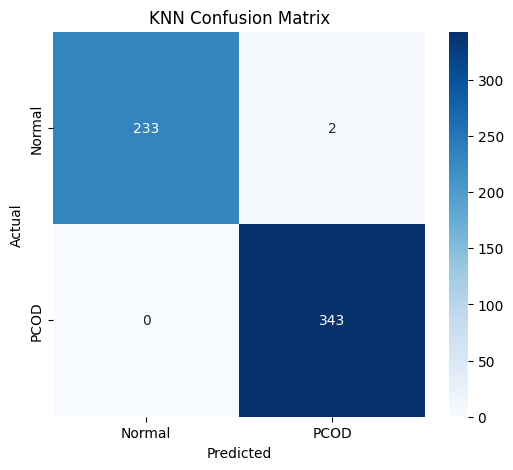


===== SVM =====
Confusion Matrix:
[[235   0]
 [  1 342]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       235
        PCOD       1.00      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



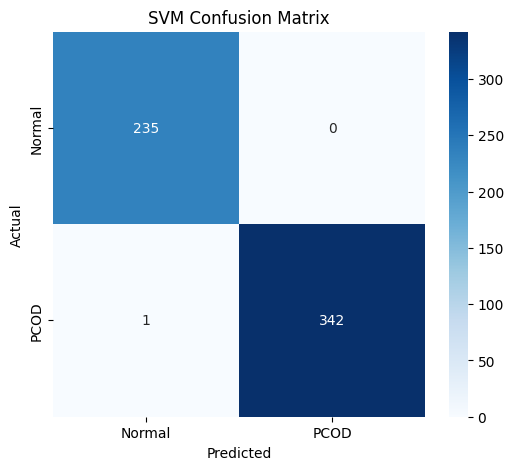


===== Random Forest =====
Confusion Matrix:
[[233   2]
 [  2 341]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       235
        PCOD       0.99      0.99      0.99       343

    accuracy                           0.99       578
   macro avg       0.99      0.99      0.99       578
weighted avg       0.99      0.99      0.99       578



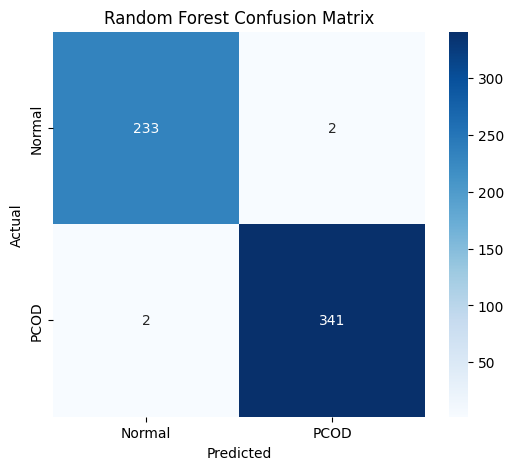


===== Logistic Regression =====
Confusion Matrix:
[[235   0]
 [  1 342]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       235
        PCOD       1.00      1.00      1.00       343

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



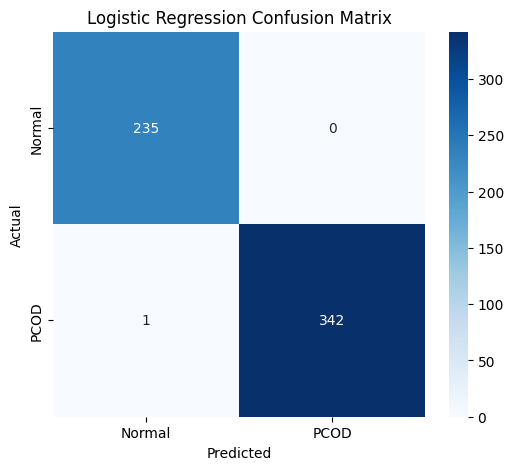

In [18]:
class_names = ["Normal", "PCOD"]
#KNN
evaluate_model(
    y_test,
    y_pred_knn,
    model_name="KNN",
    class_names=class_names
)
#SVM
evaluate_model(
    y_test,
    y_pred_svm,
    model_name="SVM",
    class_names=class_names
)
#Random Forest
evaluate_model(
    y_test,
    y_pred_rf,
    model_name="Random Forest",
    class_names=class_names
)
#Logistic Regression
evaluate_model(
    y_test,
    y_pred_lr,
    model_name="Logistic Regression",
    class_names=class_names
)




In [19]:
print("===== MODEL ACCURACIES (%) =====\n")

print(f"KNN Accuracy: {knn_acc * 100:.2f}%")
print(f"SVM Accuracy: {svm_acc * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")
print(f"Logistic Regression Accuracy: {lr_acc * 100:.2f}%")


===== MODEL ACCURACIES (%) =====

KNN Accuracy: 99.65%
SVM Accuracy: 99.83%
Random Forest Accuracy: 99.31%
Logistic Regression Accuracy: 99.83%


In [20]:
import pandas as pd

accuracy_dict = {
    "KNN": knn_acc * 100,
    "SVM": svm_acc * 100,
    "Random Forest": rf_acc * 100,
    "Logistic Regression": lr_acc * 100
}

accuracy_df = pd.DataFrame.from_dict(
    accuracy_dict,
    orient='index',
    columns=["Accuracy (%)"]
)

print("\n===== ACCURACY COMPARISON TABLE =====")
accuracy_df

best_model = accuracy_df["Accuracy (%)"].idxmax()
best_accuracy = accuracy_df["Accuracy (%)"].max()

print("\n===== BEST MODEL =====")
print(f"Best Model: {best_model}")
print(f"Best Accuracy: {best_accuracy:.2f}%")



===== ACCURACY COMPARISON TABLE =====

===== BEST MODEL =====
Best Model: SVM
Best Accuracy: 99.83%


In [21]:
import numpy as np
import matplotlib.pyplot as plt


In [23]:
# Extract significant features only
X_train_sig = X_train[:, significant_idx]

# Separate classes
normal_sig   = X_train_sig[y_train == 0]
infected_sig = X_train_sig[y_train == 1]

# Mean of each significant feature
mean_normal   = np.mean(normal_sig, axis=0)
mean_infected = np.mean(infected_sig, axis=0)

# Stack means for normalization
means = np.vstack((mean_normal, mean_infected))

# Min–Max normalization
means_norm = (means - means.min(axis=0)) / (means.max(axis=0) - means.min(axis=0) + 1e-8)

mean_normal_norm   = means_norm[0]
mean_infected_norm = means_norm[1]



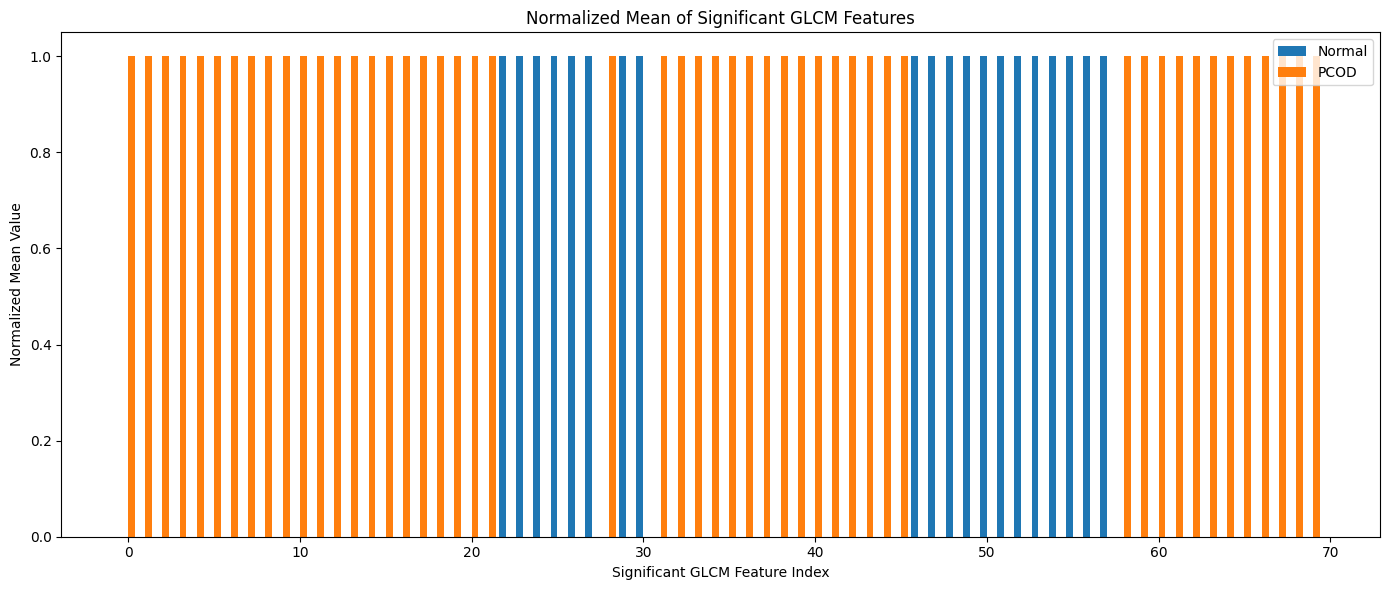

In [24]:
plt.figure(figsize=(14, 6))

x = np.arange(len(significant_idx))
width = 0.4

plt.bar(x - width/2, mean_normal_norm, width, label='Normal')
plt.bar(x + width/2, mean_infected_norm, width, label='PCOD')

plt.xlabel("Significant GLCM Feature Index")
plt.ylabel("Normalized Mean Value")
plt.title("Normalized Mean of Significant GLCM Features")
plt.legend()
plt.tight_layout()
plt.show()


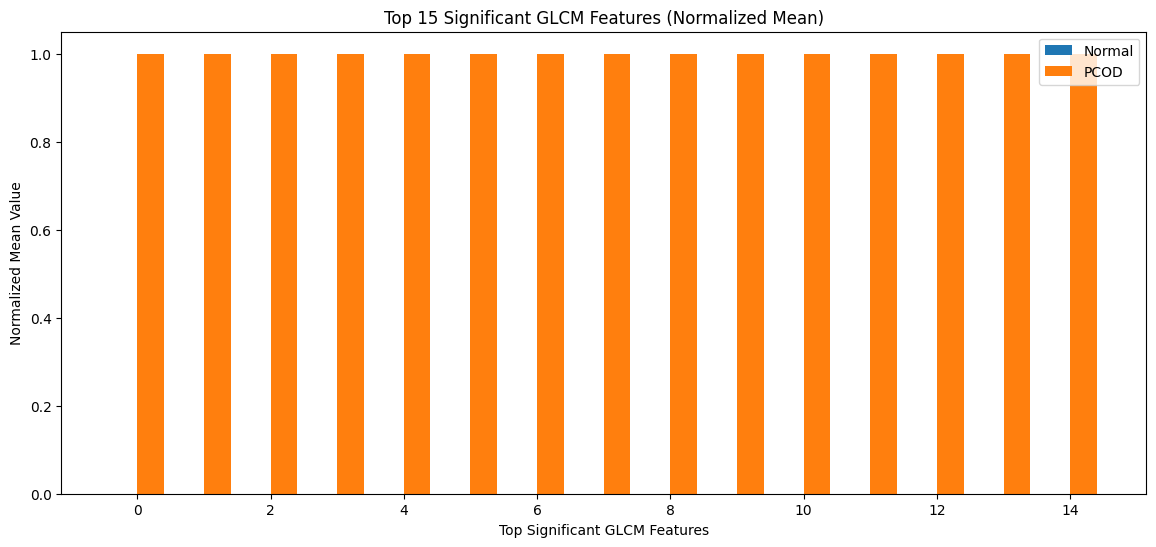

In [25]:
top_n = 15

plt.figure(figsize=(14, 6))
x = np.arange(top_n)

plt.bar(x - 0.2, mean_normal_norm[:top_n], 0.4, label='Normal')
plt.bar(x + 0.2, mean_infected_norm[:top_n], 0.4, label='PCOD')

plt.xlabel("Top Significant GLCM Features")
plt.ylabel("Normalized Mean Value")
plt.title("Top 15 Significant GLCM Features (Normalized Mean)")
plt.legend()
plt.show()
